# Shortest path

A common graph problem is finding the shortest path between two or more vertices. Consider this graph:

In [1]:
def make_list_graph(n_vertices):
    return [[] for _ in range(n_vertices)]
    
def add_list_edge(graph, source, target):
    if target not in graph[source]:
        graph[source].append(target)
        
g = make_list_graph(6)

add_list_edge(g, 0, 1)
add_list_edge(g, 0, 5)
add_list_edge(g, 1, 2)
add_list_edge(g, 1, 3)
add_list_edge(g, 2, 4)
add_list_edge(g, 3, 5)
add_list_edge(g, 5, 1)

print(g)

[[1, 5], [2, 3], [4], [5], [], [1]]


The graph we just constructed looks like this:

![](figures/small-graph.png)

The shortest paths from 0 to 4 and 5, respectively, are highlighted.

In JVG, there is an algorithm for finding the shortest path between two nodes using a depth first traversal of a graph. Below is my implementation of this idea. My version is a bit more efficient since I do not concatenate lists to keep track of the current candidate path--something that takes time proportional to the length of the list--and I use bit-vectors to check if a given node is on the current path, which is a constant time operation, instead of using

```python
node not in path
```

which is another linear time operation.

In [2]:
def dfs(graph, v, t, current_path, on_path, shortest_ref):
    if v == t:
        shortest = shortest_ref[0]
        if shortest is None or len(current_path) < len(shortest):
            shortest_ref[0] = current_path[:]
    else:
        for w in graph[v]:
            if not on_path[w]:
                current_path.append(w)
                on_path[w] = True
                dfs(graph, w, t, current_path, on_path, shortest_ref)
                current_path.pop()
                on_path[w] = False
    

def dfs_path(graph, s, t):
    shortest_ref = [None]
    on_path = [False] * len(graph)
    current_path = [s]
    on_path[s] = True
    dfs(graph, s, t, current_path, on_path, shortest_ref)
    return shortest_ref[0]

print(dfs_path(g, 0, 4))
print(dfs_path(g, 0, 5))

[0, 1, 2, 4]
[0, 5]


There is a bit of a hack in this implementation that allows me to update the shortest path seen so far as part of the traversal as a side effect. In the book's implementation, he returns paths as part of recursive calls. That is also potentially inefficient since it involves copying. I copy the best path seen so far when I identify one, but to be able to assign this to a variable I need either a global variable and a trick I haven't shown you, or I need some kind of indirection. Here, I make a list, `shortest_ref`, that contain a single element, which is the shortest path. If I assign to the variable `shortest_ref` inside `dfs`, Python will think I'm writing to a local variable, and the assignment cannot be seen by `dfs_path`. Instead, I write to `shortest_ref[0]`. I modify the list instead of the variable. And *this*, `dfs_path` can see. It is a hack, but it works.

The idea is illustrated in this figure:

![](figures/reference.png)

The two `shortest_ref` variables are both local variables and independent, but they both refer to the same list, and when we modify the list, both functions can see it.

I have tried to make the implementation of this algorithm as efficient as I can, without hurting readability, but there are limits to what can be done if we search for shortest paths using a depth first traversal like this. We potentially have to search all possible paths, and there can be lots of those. In the book, there is an optimisation that prevents the function from traversing paths that are longer than the shortest we have seen so far, but this doesn't alleviate the problem of having to traverse a lot of paths. If we construct a graph with a grid shape as this:

![](figures/grid-graph.png)

(where here, $n$ refers to the size of the two dimensions, the number of vertices is $n^2$), all paths from the top left to the bottom have the same length, $2n$. The depth first traversal has to run through them all to figure out which is shortest.

In [3]:
def make_grid_graph(n):
    graph = make_list_graph(n*n)
    for i in range(n):
        for j in range(n-1):
            add_list_edge(graph, i*n + j, i*n + j + 1)
    for i in range(n-1):
        for j in range(n):
            add_list_edge(graph, i*n + j, (i+1)*n + j)
    return graph        

n = 3
gg = make_grid_graph(n)
print(gg)
print(dfs_path(gg, 0, n*n-1))

[[1, 3], [2, 4], [5], [4, 6], [5, 7], [8], [7], [8], []]
[0, 1, 2, 5, 8]


The number of paths through this graph is ${2n \choose n}$. You see this by first observing that all paths have length $2n$ and all contain exactly $n$ steps down and $n$ steps to the right, and you can pick any of the $2n$ steps to be the $n$ down (or right) steps.

In [4]:
from scipy.misc import comb as choose
choose(2*n, n)

20.0

This is known as the *central binomial coefficient* and can be approximated by ${2n \choose n} \sim \frac{4^n}{\sqrt{\pi n}}$.

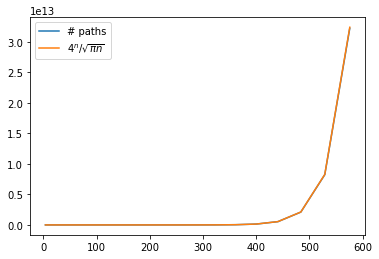

In [5]:
import matplotlib.pyplot as plt
import math 

ns = range(2, 25)
graph_size = [n*n for n in ns]

fig, ax = plt.subplots()
ax.plot(graph_size, [choose(2*n, n) for n in ns], label='# paths')
ax.plot(graph_size, [4**n / math.sqrt(math.pi * n) for n in ns], label="$4^n / \sqrt{\pi n}$")

ax.legend()
plt.show()

This is an exponential function, so clearly, exploring *all* paths has poor worst-case performance.

We can take a different approach, using a method known ad *Dikjkstra's shortest path algorithm*. This algorithm finds the length of the shortest path from one node, $s$ to all other nodes in time $O(n^2)$, and from that we can backtrack to extract a shortest path.

The algorithm works like this: we construct a list with the distance from $s$ to all other vertices $v$. Initially, this contains $\infty$ at all entries. We then set the distance from $s$ to itself to be zero. We also keep track of all the vertices we have seen in our graph traversal, and all the vertices we have already processed. Initially, this is just $s$ as well. Then, iteratively, we pick the vertix $v$ among the seen, but not processed, vertices with the smallest distance to $s$ (in the first iteration this must be $s$ so we don't need to search for it there). We iterate through all it's neighbours, the vertices $w$ where we have edges $(v,w)$, and we compute the shortest distance to those. This is either a distance that can reach them through some other path we have previously explored or it is the distance to $v$ plus one. We make sure to mark the $w$s as having been seen (we don't have to worry about them being processed--if they have, we have already recored that), and finally we mark $v$ as processed--so we do not do it again--and then pick a new $v$ from the remaining seen but not processed.

We continue doing this as long as there are nodes we have seen but not processed. When there are no more such nodes, we have reached all nodes that can be reached from $s$ and we have computed the distance to them. Those that are not reachable from $s$ will have infinity as their distance, which is appropriate. The algorithm is implemented below. Mentally, go through the two loops inside `dijkstra` and convince you that the running time is $O(n^2)$.

In [6]:
def argmin_seen(dist, seen, processed):
    v, d = None, float("Inf")
    for i, dd in enumerate(dist):
        if seen[i] and not processed[i] and dd < d:
            v, d = i, dd
    return v

def dijkstra(graph, s):
    seen = [False] * len(graph)
    processed = [False] * len(graph)
    dist = [float("Inf")] * len(graph)
    
    dist[s] = 0
    seen[s] = True
    v = s
    while v is not None:
        for w in graph[v]:
            if not processed[w]:
                dist[w] = min(dist[w], dist[v] + 1)
                seen[w] = True
        processed[v] = True
        v = argmin_seen(dist, seen, processed)
    
    return dist
    
dist = dijkstra(g, 0)
print(dist)

[0, 1, 2, 2, 3, 1]


Dijkstra's algorithm only computes the *length* of the shortest paths from $s$ to all the others. To get the actual paths, we need implement an algorithm that is similar to the backtracking algorithm we saw when we looked at pairwise alignments. To get the shortest path from $s$ to $t$, we need to search from $t$ to $s$ and always take, as the next node in the path we construct, one whose distance is one less than the previous. Since we are working with oriented graphs, we first need to reverse the edges, so we can move backwards through it efficiently (if the graphs were not oriented we wouldn't need to do this), but other than this, the backtracking is fairly straightforward.

In [7]:
def reverse_graph(graph):
    reverse = make_list_graph(len(graph))
    for v in range(len(graph)):
        for w in graph[v]:
            add_list_edge(reverse, w, v)
    return reverse

def back_track(graph, dist, s, t):
    reverse = reverse_graph(graph)
    reverse_path = [t]
    v = t
    while v != s:
        for w in reverse[v]:
            if dist[v] == dist[w] + 1:
                reverse_path.append(w)
                v = w
                break
    return list(reversed(reverse_path))

print(reverse_graph(g))
print(back_track(g, dist, 0, 4))
print(back_track(g, dist, 0, 5))

[[], [0, 5], [1], [1], [2], [0, 3]]
[0, 1, 2, 4]
[0, 5]


We combine the two algorithms to get a function for obtaining a shortest path:

In [8]:
def dijkstra_path(graph, s, t):
    dist = dijkstra(graph, s)
    return back_track(graph, dist, s, t)

As expected, the second algorithm is far faster on grid graphs.

In [9]:
n = 10
large_graph = make_grid_graph(n)
%timeit dfs_path(large_graph, 0, n*n-1)
%timeit dijkstra_path(large_graph, 0, n*n-1)

90.7 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
862 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## All-pairs shortest path

Using Dijkstra's algorithm, we can find all pairwise distances by calling the algorithm for all source nodes. This will take time $O(n^3)$. Another algorithm with the same complexity, but which due to its simplicity is often faster in practise, is the *Floyd-Warshall* algorithm. This algorithm uses the matrix representation of graphs:

In [10]:
import numpy as np

def make_matrix_graph(n_vertices):
    return np.zeros(shape = (n_vertices, n_vertices), dtype=int)

def add_matrix_edge(graph, i, j):
    graph[i,j] = 1

In [11]:
mg = make_matrix_graph(6)

add_matrix_edge(mg, 0, 1)
add_matrix_edge(mg, 0, 5)
add_matrix_edge(mg, 1, 2)
add_matrix_edge(mg, 1, 3)
add_matrix_edge(mg, 2, 4)
add_matrix_edge(mg, 3, 5)
add_matrix_edge(mg, 5, 1)

print(mg)

[[0 1 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]]


The algorithm works by iteratively updating a matrix that contains all pairwise distances. Initially, we set all distances to $\infty$, except for the diagonal distances, from nodes to themselves, that we set to zero, and we set the distance between directly connected nodes $(v,w)$ to 1.

In [12]:
def make_dist_matrix(graph):
    n = graph.shape[0]
    weights = np.empty(shape=(n,n))
    weights[:] = float("Inf")
    np.fill_diagonal(weights, 0)
    weights[graph == 1] = 1
    return weights

print(make_dist_matrix(mg))

[[  0.   1.  inf  inf  inf   1.]
 [ inf   0.   1.   1.  inf  inf]
 [ inf  inf   0.  inf   1.  inf]
 [ inf  inf  inf   0.  inf   1.]
 [ inf  inf  inf  inf   0.  inf]
 [ inf   1.  inf  inf  inf   0.]]


The algorithm now iteratively update the distance between all nodes. In iteration $k$, it will have computed the distance between all pairs of nodes where you can get from the first node to the second using only nodes with index less than $k$. In iteration $k=0$, we will have the initial distance matrix, which contains zeros for empty paths and ones for paths of length one. Only the zero-entries are really relevant for paths going through nodes with index zero or less, but the invariant is only that we have all the paths doing that; we do not rule out having others as well. In each following iteration $k$, we add to the existing paths the posibility of going through the node with index $k$. We take the previous distance matrix, call it `old`, and we compute the updated one, call it `new`, using the formula

$$\mathrm{new}[i,j] = \min(\mathrm{old}[i,j], \mathrm{old}[i,k] + \mathrm{old}[k,j])$$

The formula is similar to the one we used in Dijkstra's algorithm. We have already found a shorter path, using smaller indices, or we can get from node $i$ to $k$ and then from $k$ to $j$ in fewer steps than we could if we didn't use $k$. (There is no need to consider more than the shortest path from $i$ to $k$ and then from $k$ to $j$ here, because any other options would either be entirely using indices smaller than $k$, and thus captured by $\mathrm{old}[i,j]$, or they would involved more than one trip through node $k$ and then couldn't be shortest).

The algorithm simply looks like this:

In [13]:
def floyd(graph):
    n = graph.shape[0]
    d = make_dist_matrix(graph)
    new, old = d, d.copy()
    for k in range(n):
        for i in range(n):
            for j in range(n):
                new[i,j] = min(old[i,j], old[i,k] + old[k,j])
        old, new = new, old
    return new

print(floyd(mg))

[[  0.   1.   2.   2.   3.   1.]
 [ inf   0.   1.   1.   2.   2.]
 [ inf  inf   0.  inf   1.  inf]
 [ inf  inf  inf   0.  inf   1.]
 [ inf  inf  inf  inf   0.  inf]
 [ inf   1.   2.   2.   3.   0.]]


Here, I construct the distance matrix, `d`, and then make a copy, `d.copy()`, so I can modify the two copies I have of it independently.

We can construct a version of Dijkstra's algorithm that computes all pairwise distances:

In [14]:
def all_pairs_dijkstra(graph):
    n = len(graph)
    return np.array([dijkstra(graph,i) for i in range(n)])

print(all_pairs_dijkstra(g))

[[  0.   1.   2.   2.   3.   1.]
 [ inf   0.   1.   1.   2.   2.]
 [ inf  inf   0.  inf   1.  inf]
 [ inf   2.   3.   0.   4.   1.]
 [ inf  inf  inf  inf   0.  inf]
 [ inf   1.   2.   2.   3.   0.]]


We can then compare its performance with that of Floyd-Warshall. For the small example graph we have used in these notes, the overhead of `floyd`, where we have to manipulate a couple of tables, makes it slow.

In [15]:
%timeit floyd(mg)
%timeit all_pairs_dijkstra(g)

183 µs ± 2.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
46.9 µs ± 1.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now, we might hope that this is a consequence of the example graph being small and fairly connected, so the Dijkstra algorithm gets to the shortest paths quickly, but the performance difference remains for larger graphs as well:

In [16]:
import numpy as np

def make_random_graph(n, k):
    graph = make_list_graph(n)
    for i in range(n):
        for j in np.random.choice(n, size = k):
            add_list_edge(graph, i, j)
    return graph        

rg = make_random_graph(110, 100)

def list_graph_to_matrix_graph(graph):
    n = len(graph)
    mgraph = make_matrix_graph(n)
    for i in range(n):
        for j in graph[i]:
            mgraph[i,j] = 1
    return mgraph

mrg = list_graph_to_matrix_graph(rg)

%timeit all_pairs_dijkstra(rg)
%timeit floyd(mrg)

278 ms ± 868 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
932 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The real issue here is not so much the algorithm, though, but the overhead there is with looks in Python. These are slower than loops implemented in the underlying C, and for the list comprehensions we used for Dijkstra's algorithm, we exploit those. Invoking Numpy to deal with the inner-most loop, we can improve upon this. The example code below is a bit hard to read, so don't worry too much about it. It is essentially the same algorithm, just with the `j` loop handled by Numpy.

In [20]:
def floyd(graph):
    n = graph.shape[0]
    d = make_dist_matrix(graph)
    for k in range(n):
        for i in range(n):
            d[i,:] = np.minimum(d[i,:], d[i,k] + d[k,:]) 
    return d

floyd(mg)

array([[  0.,   1.,   2.,   2.,   3.,   1.],
       [ inf,   0.,   1.,   1.,   2.,   2.],
       [ inf,  inf,   0.,  inf,   1.,  inf],
       [ inf,   2.,   3.,   0.,   4.,   1.],
       [ inf,  inf,  inf,  inf,   0.,  inf],
       [ inf,   1.,   2.,   2.,   3.,   0.]])

With this implementation, the Floyd-Warshal algorithm outperform Dijkstra's.

In [19]:
%timeit all_pairs_dijkstra(rg)
%timeit floyd(mrg)

286 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
28.2 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Don't worry too much if you do not understand the last version of the algorithm. I only show it here to make it clear that the performance difference is not because of the algorithm but because of different optimisations of the loops.

If we had more time in the class to experiment with Numpy and the options you have for solving problems there, we could explore it more. Many of these operations are faster because they use underlying C or FORTRAN routines. You will see some C code towards the end of the class, and there you get a chance to experiment with that.